In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [42]:
birth = pd.read_csv('subsampled_clean_data.csv')

In [43]:
birth.head()

,Unnamed: 0,ATTEND,BFACIL,BMI,DBWT,DMAR,FAGECOMB,FEDUC,FRACE6,LD_INDL,...,PRIORLIVE,PRIORTERM,RDMETH_REC,RESTATUS,RF_CESAR,SEX,PREG_LEN,WTGAIN_PER,CIG,FIRST_BIRTH
0,2780164,1,1,31.4,3670,1,29,6,1,N,...,False,False,1,2,N,M,9,0.000000,False,True
1,1306496,2,1,27.6,3494,1,34,4,1,Y,...,True,False,1,1,N,F,9,0.120482,False,False
2,3027006,1,1,27.1,3374,2,43,2,1,N,...,True,True,1,1,N,M,10,0.061350,True,False
3,903600,1,1,26.8,3520,1,30,3,1,Y,...,False,True,1,1,N,M,9,0.301282,False,True
4,2813944,1,1,21.3,3140,1,30,5,1,N,...,False,False,1,3,N,M,9,0.208333,False,True


# Research Question

Predicting a baby's birth weight from Mother’s Single Years of Age and Number of Prenatal Visits, comparing GLMs to nonparametric methods.

# Goal

We are trying to use various models including GLMs and Nonparametric methods to predict baby's birth weights. In the original EDA and using our domain knowledge on newborn health, we proposed two features that will be helpful for constructing the model, **Mother’s Single Years of Age (MAGER)** and **Number of Prenatal Visits (PREVIS)**. \
**MAGER**: Using our common knowledge, we think that younger mothers are likely to have healthier babies and thus higher birth weights. \
**PREVIS**: Using our common knowledge, we think that more prenatal visits means that the family pays more attention to the pregnancy and thus is likely to have babies with higher birth weights.

# Nonparametric Method-Decision Tree

**Why Decision Tree**\
For nonparametric methed like decision tree, we do not need to consider about selecting the features. Since the impurity and impurity reduction will do the heavy lifting. The first few depths will select the best features and threshold that decrease the impurity the most, which help us to see which features are the best for the prediction. \
\
**Assumption**
1. By using Decision Tree, we assume that the relationship is non linear and complex.
2. Since y is continuous, we will be using regression tree from CART, the DecisionTreeRegressor. We need to realize some mechanics of the model in order to make some assumption about our dataset: The model takes in X and y as input, and it tries to iterate through all the possible features in X and iterate thourgh all the values(threshold) that particular feature can be. And calculate the impurity reduction of such split, where $$Impurity = \frac{1}{N_n(t)}\sum_{i:X_i \in R_i} (y_i - \mu_n(t))^2  \hspace{1cm} (1)$$ and **Impurity reduction** $$\Delta_I(t) = Impurity(t) - \frac{N_n(t^{left})}{N_n(t)}Impurity(t^{left}) - \frac{N_n(t^{right})}{N_n(t)}Impurity(t^{right})  \hspace{1cm} (2)$$ 
Impurity calculates the weighted sum of difference between mean and each sample's label squared in a tree node, which basically tells how pure a particular node is. The Impurity reduction calculates the difference between the Impurity before split and the weighted sum of the Impurity of nodes after split. Since there's mean involved in the model, we need to make all the data to continuous, we will achieve this by performing one-hot encoding.

### Baby Weights (y)

In [44]:
y = np.array(birth['DBWT'])
y

array([3670, 3494, 3374, ..., 2710, 3118, 3020])

### Valid features to construct the tree (X)

In [45]:
# Drop irrelevant features and y
X_drop = birth.drop(['DBWT', 'Unnamed: 0', 'DMAR'], axis = 1)
X_drop.head()

,ATTEND,BFACIL,BMI,FAGECOMB,FEDUC,FRACE6,LD_INDL,MAGER,MBSTATE_REC,MEDUC,...,PRIORLIVE,PRIORTERM,RDMETH_REC,RESTATUS,RF_CESAR,SEX,PREG_LEN,WTGAIN_PER,CIG,FIRST_BIRTH
0,1,1,31.4,29,6,1,N,32,1,6,...,False,False,1,2,N,M,9,0.000000,False,True
1,2,1,27.6,34,4,1,Y,33,1,7,...,True,False,1,1,N,F,9,0.120482,False,False
2,1,1,27.1,43,2,1,N,29,1,2,...,True,True,1,1,N,M,10,0.061350,True,False
3,1,1,26.8,30,3,1,Y,28,1,7,...,False,True,1,1,N,M,9,0.301282,False,True
4,1,1,21.3,30,5,1,N,30,1,4,...,False,False,1,3,N,M,9,0.208333,False,True


In [46]:
# Get all the categorical data
cat_cols = X_drop.select_dtypes(exclude=["number"]).columns
cat_cols

Index(['LD_INDL', 'PRIORDEAD', 'PRIORLIVE', 'PRIORTERM', 'RF_CESAR', 'SEX',
       'CIG', 'FIRST_BIRTH'],
      dtype='object')

In [47]:
for c in cat_cols:
    encoded = pd.get_dummies(X_drop[c], prefix=c)
    X_drop = pd.concat([X_drop, encoded], axis='columns')

In [48]:
X_encoded = X_drop.drop(cat_cols, axis = 1)

In [49]:
X_encoded.head()

,ATTEND,BFACIL,BMI,FAGECOMB,FEDUC,FRACE6,MAGER,MBSTATE_REC,MEDUC,MRAVE6,...,PRIORTERM_False,PRIORTERM_True,RF_CESAR_N,RF_CESAR_Y,SEX_F,SEX_M,CIG_False,CIG_True,FIRST_BIRTH_False,FIRST_BIRTH_True
0,1,1,31.4,29,6,1,32,1,6,1,...,1,0,1,0,0,1,1,0,0,1
1,2,1,27.6,34,4,1,33,1,7,1,...,1,0,1,0,1,0,1,0,1,0
2,1,1,27.1,43,2,1,29,1,2,1,...,0,1,1,0,0,1,0,1,1,0
3,1,1,26.8,30,3,1,28,1,7,1,...,0,1,1,0,0,1,1,0,0,1
4,1,1,21.3,30,5,1,30,1,4,1,...,1,0,1,0,0,1,1,0,0,1


### Fit

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.01, random_state=0)

In [11]:
depths = [i for i in range(1, 10)]
train_scores = np.ones(len(depths))
test_scores = np.ones(len(depths))

#### Cross validation

In [12]:
for idx in range(len(depths)):
    clf = tree.DecisionTreeRegressor(max_depth = depths[idx])
    clf.fit(X_train, y_train)
    train_scores[idx] = clf.score(X_train, y_train)
    test_scores[idx] = clf.score(X_test, y_test)
    print("Max depths" ,depths[idx] , "will have train score" , train_scores[idx] , "and test score" , test_scores[idx])

Max depths 1 will have train score 0.15722212437225924 and test score 0.12774532540632055
Max depths 2 will have train score 0.23653748245476214 and test score 0.22971336641048823
Max depths 3 will have train score 0.26145146321359913 and test score 0.21841821841646225
Max depths 4 will have train score 0.2864851728757737 and test score 0.2692236761573288
Max depths 5 will have train score 0.30956300362718303 and test score 0.2591029708037196
Max depths 6 will have train score 0.33911101131747656 and test score 0.26877151389971643
Max depths 7 will have train score 0.3766485557353514 and test score 0.2162482576076865
Max depths 8 will have train score 0.42306787845459326 and test score 0.2156016222426992
Max depths 9 will have train score 0.47492748583367006 and test score 0.16807984123997877


According to the cross validation, max_depth = 4 looks promising, so that's what we will use in the prediction phase

In [13]:
clf = tree.DecisionTreeRegressor(max_depth = 4)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

### Summarize and interpret 

#### Visualize tree

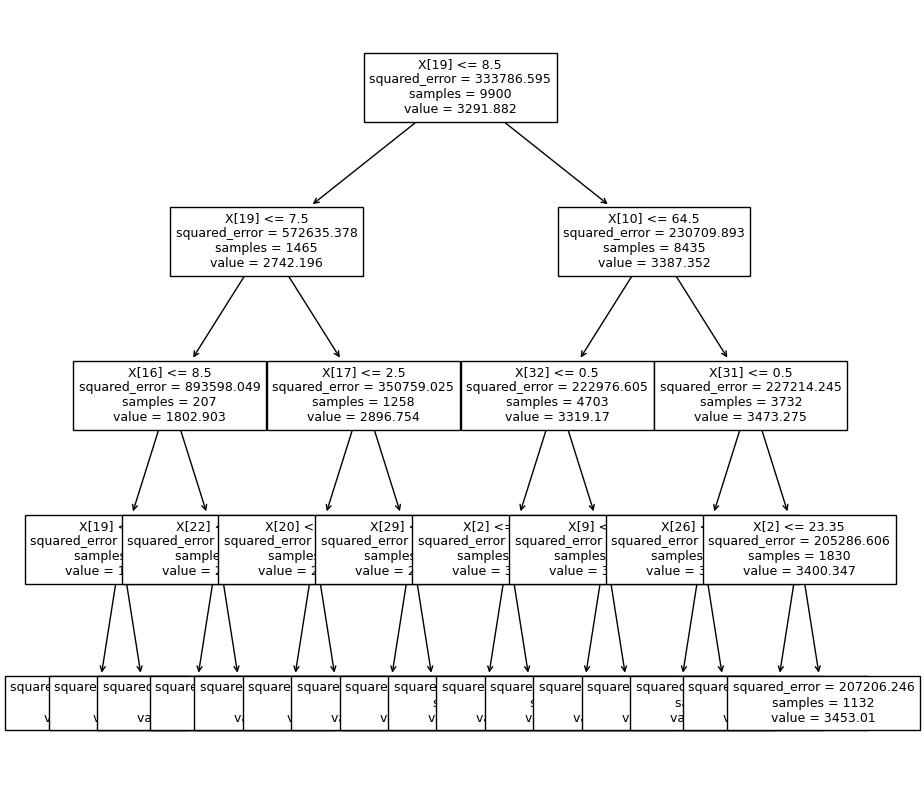

In [14]:
plt.figure(figsize=(10,10))
tree.plot_tree(clf, fontsize=9)
plt.show()

In [15]:
clf.feature_names_in_[19], clf.feature_names_in_[10], clf.feature_names_in_[16]

('PREG_LEN', 'M_Ht_In', 'PREVIS')

According to the tree we got, the features like **number of pregnancy months (PREG_LEN)** and **Mother's height (M_HT_In)** helps the most. This makes sense because: \
(1) the longer baby stay in mother's body, the more likely they can get more nutrition from nutrient transfer and thus more heavy \
(2) the taller mother may have a higher chance to have a taller baby, and it will make the weights change

#### Ploting the true labels and predicted labels

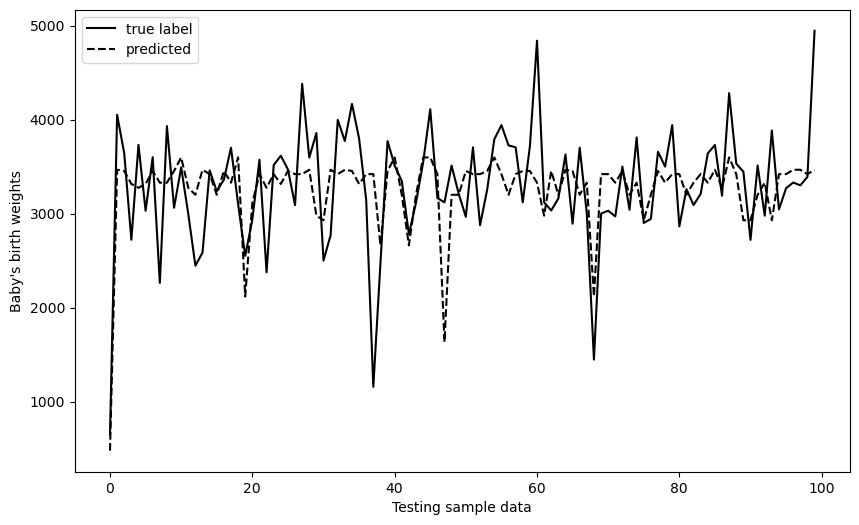

In [16]:
plt.rcParams['figure.figsize'] = (10, 6)
x_ax = range(len(X_test))
plt.plot(x_ax, y_test, label = 'true label', color = 'k', linestyle = '-')
plt.plot(x_ax, clf.predict(X_test), label = 'predicted', color = 'k', linestyle = '--')
plt.ylabel("Baby's birth weights")
plt.xlabel("Testing sample data")
plt.legend()
plt.show()

As the plot indicates, although the score of the model isn't the best, but it actually perform decently. The overlap between true label and predicted label is fair considering they are continuous.

# Nonparametric Method-Random Forest

In [17]:
clf1 = RandomForestRegressor(n_estimators= 200,max_depth=15)

In [18]:
clf1.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200)

In [19]:
clf1.score(X_train, y_train)

0.7972751557262469

In [20]:
clf1.score(X_test, y_test)

0.33232286847532067

### Summarize and interpret 

We are unable to interpret the model since random forest is a ensemble algorithms that takes vote from hundreds of learners. Although the crowds' decision helps to lower the variance, it is unable to interpret anymore 

#### Ploting the true labels and predicted labels

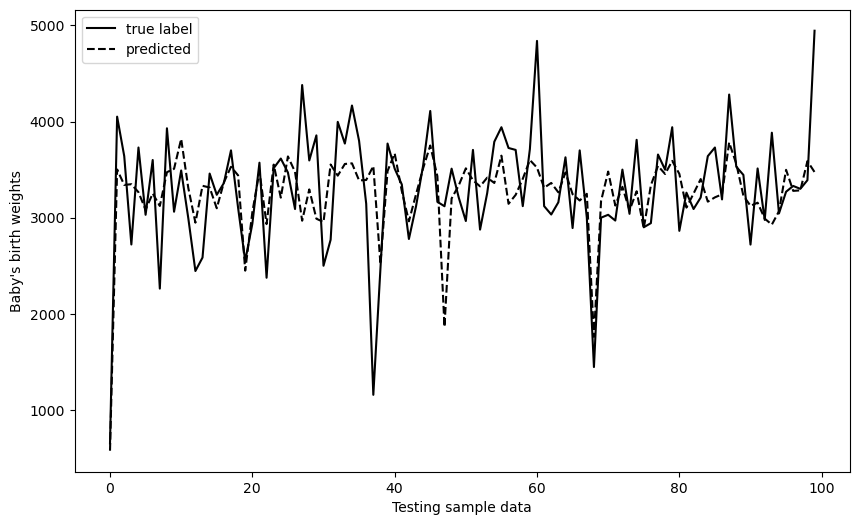

In [21]:
plt.rcParams['figure.figsize'] = (10, 6)
x_ax = range(len(X_test))
plt.plot(x_ax, y_test, label = 'true label', color = 'k', linestyle = '-')
plt.plot(x_ax, clf1.predict(X_test), label = 'predicted', color = 'k', linestyle = '--')
plt.ylabel("Baby's birth weights")
plt.xlabel("Testing sample data")
plt.legend()
plt.show()

# GLM

In [50]:
#import the pymc3 package
import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

## Choice of Model - Linear Regression

From EDA, we see that DBWT, MAGER, and PREVIS plots are all roughly normal distributed, so the best choice of model here is Linear Regression. \
\
**Inverse Link Function:** Identity \
**Likelihood:** Gaussian

This means that we will model birth weight as $W_i \sim N(\beta_0 + \beta_1M_i + \beta_2P_i, \sigma^2 I_n)$ where $M_i$ is MAGER and $P_i$ is PREVIS. 

## Frequentist Regression

In [52]:
freq_model = sm.GLM(birth.DBWT, exog = sm.add_constant(birth[['MAGER','PREVIS']]), 
                  family=sm.families.Gaussian())
freq_res = freq_model.fit()
print(freq_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   DBWT   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                      3.2879e+05
Method:                          IRLS   Log-Likelihood:                -77704.
Date:                Sun, 04 Dec 2022   Deviance:                   3.2869e+09
Time:                        10:26:51   Pearson chi2:                 3.29e+09
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3014.8158     34.136     88.318      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


We see that the prediction is $W_i = 3014.8158 + 2.0604M_i + 18.5685P_i$. This means that older mothers have babies with higher birth weights, and mothers who go to more prenatal visists also have babies with higher birth weights.

## Bayesian Regression

In [1]:
with pm.Model() as bayes_model:
    glm.GLM.from_formula('DBWT ~ MAGER + PREVIS', birth, family=glm.families.Normal())
    trace_gaussian = pm.sample(1000, cores=1, target_accept=0.95)

In [32]:
freq_model_2 = sm.GLM(birth.DBWT, exog = sm.add_constant(birth[['PREG_LEN','M_Ht_In']]), 
                  family=sm.families.Gaussian())
freq_res_2 = freq_model_2.fit()
print(freq_res_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   DBWT   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                      2.8549e+05
Method:                          IRLS   Log-Likelihood:                -76998.
Date:                Sun, 04 Dec 2022   Deviance:                   2.8540e+09
Time:                        09:51:25   Pearson chi2:                 2.85e+09
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1013.9968    135.710     -7.472      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
